In [798]:
import pandas as pd
import numpy as np
import joblib
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold 
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Load dataset
df = pd.read_csv('/Users/emme/Desktop/ca1-dataset.csv')

# group by namea
group_dict = {}
groups = np.array([])

for index, row in df.iterrows():
    name = row['namea']
    if name not in group_dict:
        group_dict[name] = index
    groups = np.append(groups, group_dict[name])
    
# set up X abd y to predict 'OffTask'   
X = df.drop(columns=['OffTask']+['Unique-id']+['namea'], axis=1)  
y = df['OffTask'] 
y = y.map({'N': 0, 'Y': 1})

# Initialize a list to store kappa scores for each fold
kappa_scores = list()

In [799]:
# Perform 10-fold student-level batch cross-validation
gkf = GroupKFold(n_splits=10)
for train_index, test_index in gkf.split(X, y, groups=groups):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]  

    # Get feature importances
    k = 5
    selector = SelectKBest(score_func=mutual_info_classif, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    # Create and fit the classifier to training data
    model = XGBClassifier()
    model.fit(X_train_selected, y_train)

    # Make predictions on test data
    y_pred = model.predict(X_test_selected)


In [800]:
# Calculate Cohen's Kappa score to evaluate the model
kappa = cohen_kappa_score(y_test, y_pred)
kappa_scores.append(kappa)

# Calculate mean kappa score across all folds
mean_kappa = np.mean(kappa_scores)

# Print the mean kappa score 
print(f"Mean Cohen's Kappa (10-fold cross-validation with feature selection): {mean_kappa:.2f}")

# Calculate other scores
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)
roc_auc = roc_auc_score(y_test, y_pred)

# Print the computed metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

Mean Cohen's Kappa (10-fold cross-validation with feature selection): 0.27
Accuracy: 0.93
Recall: 0.17
F1-Score: 0.29
ROC AUC: 0.58


In [801]:
## Save the trained model to a file using joblib
model_filename = 'trained_model.joblib'
joblib.dump(model, model_filename)

print(f"Model saved as '{model_filename}'")

Model saved as 'trained_model.joblib'


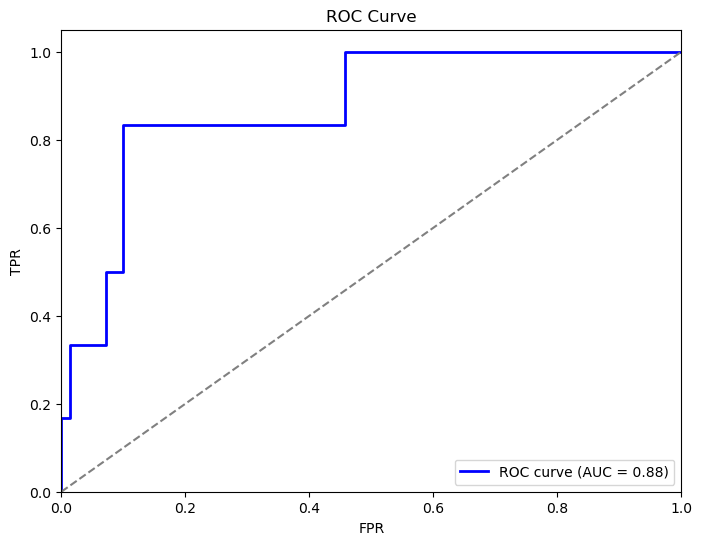

In [802]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# Predict the probabilities of the positive class (class 1)
y_pred = model.predict_proba(X_test_selected)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate the AUC 
roc_auc = roc_auc_score(y_test, y_pred)

## Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
